In [6]:
import cv2
import numpy as np

from keras.layers import Dense
%matplotlib inline
import keras
from keras.models import Sequential
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import scipy
import math
import keras
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib

from skimage.morphology import disk
from skimage.filters import threshold_otsu, rank, threshold_adaptive
from skimage import data, filters
import traceback

import PIL
import billiard
from billiard import Pool
from functools import partial
import pytesseract
import pyocr

In [7]:
def binarize(file=None):
#     img = cv2.imread('../Text-detection-in-natural-scene-images-dataset/text or no text dataset/testing/4833.jpg', 0)
    # Number of rows and columns
    
    img = cv2.imread(file, 0)
#     pil_image = Image.fromarray(img)
#     img = pil_image.resize((640, 480), Image.ANTIALIAS)
#     img = np.array(img)
    
    rows = img.shape[0]
    cols = img.shape[1]
    
    mean_value = np.mean(img, axis=(0,1))
    mean_median_diff = abs(np.median(img) - np.mean(img))
    print("Median, Mean Image", np.median(img), np.mean(img))

    # Convert image to 0 to 1, then do log(1 + I)
    img_log = np.log1p(np.array(img, dtype="float") / 255)

    # Create Gaussian mask of sigma = 10
    M = 2*rows + 1
    N = 2*cols + 1
    sigma = 10
    (X,Y) = np.meshgrid(np.linspace(0,N-1,N), np.linspace(0,M-1,M))
    center_x = np.ceil(N/2)
    center_y = np.ceil(M/2)
    gaussian_numerator = (X - center_x)**2 + (Y - center_y)**2

    # Low pass and high pass filters
    h_low = np.exp(-gaussian_numerator / (2*sigma*sigma))
    h_high = 1 - h_low

    # Move origin of filters so that it's at the top left corner to
    # match with the input image
    h_low_shift = scipy.fftpack.ifftshift(h_low.copy())
    h_high_shift = scipy.fftpack.ifftshift(h_high.copy())


    # Filter the image and crop
    image_filter = scipy.fftpack.fft2(img_log.copy(), (M,N))
    image_outlow = scipy.real(scipy.fftpack.ifft2(image_filter.copy() * h_low_shift, (M,N)))
    image_outhigh = scipy.real(scipy.fftpack.ifft2(image_filter.copy() * h_high_shift, (M,N)))

    # Set scaling factors and add
    gamma1 = 0.3
    gamma2 = 1.4
    image_out = gamma1*image_outlow[0:rows,0:cols] + gamma2*image_outhigh[0:rows,0:cols]

    # Anti-log then rescale to [0,1]
    image_hmf = np.expm1(image_out)
    
    image_hmf = (image_hmf - np.min(image_hmf)) / (np.max(image_hmf) - np.min(image_hmf))
    print("Median, Mean Image HMF", np.median(image_hmf), np.mean(image_hmf), abs(np.median(image_hmf) - np.mean(image_hmf)) * 100)
    image_hmf2 = np.array(255*image_hmf, dtype="uint8")

#     diff = abs(np.median(image_hmf) - np.mean(image_hmf)) * 100
#     if  float(136.0) <= mean_value <= float(195.0):
#         if diff >= float(1.50):
#             image_hmf2 = cv2.bitwise_not(np.array(255*image_hmf, dtype="uint8"))
#             print("Here ** 1a")
#         else:
#             print("Here ** 1b")
#             image_hmf2 = np.array(255*image_hmf, dtype="uint8")
#     elif mean_value >= float(196.0):
#         image_hmf2 = cv2.bitwise_not(np.array(255*image_hmf, dtype="uint8"))
#     else:
#         image_hmf2 = np.array(255*image_hmf, dtype="uint8")
#         print("Here ** 2")

    # Threshold the image - Anything below intensity (Random) gets set to white
    # threshold values = [100, 127]
#     image_thresh = image_hmf2 < threshold_value
#     image_thresh = 255 * image_thresh.astype("uint8")
#     cc = cv2.connectedComponents(np.uint8(cv2.bitwise_not(image_thresh)))[1]
    
     # Adaptive threshold
#     image_thresh = cv2.adaptiveThreshold(image_hmf2, 100, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 111,2)
# #     image_thresh = 255 * image_thresh.astype("uint8")
#     # connected components
#     cc  = cv2.connectedComponents(np.uint8(image_thresh))[1]

    # local otsu
#     image_hmf2 = cv2.GaussianBlur(image_hmf2, (3, 3), 0)

    radius = 50
    selem = disk(radius)

    local_otsu = rank.otsu(image_hmf2, selem)
    image_bin = np.uint8(image_hmf2>=local_otsu)
    cc_1 = cv2.connectedComponents(image_bin)[1]
    
    image_bin_2 = np.uint8(image_hmf2<=local_otsu)
    cc_2 = cv2.connectedComponents(image_bin_2)[1]
    
 
    fig, axes = plt.subplots(ncols=6, figsize=(20, 10))
    ax = axes.ravel()
    
    ax[0].imshow(img, cmap=plt.cm.gray)
    ax[0].set_title('Original')
    ax[0].axis('off')
    
    ax[1].imshow(local_otsu, cmap=plt.cm.gray)
    ax[1].set_title('Homographic')
    ax[1].axis('off')
    
    ax[2].imshow(image_bin, cmap=plt.cm.gray)
    ax[2].set_title('Threshold 1')
    ax[2].axis('off')
    
    ax[3].imshow(image_bin_2, cmap=plt.cm.gray)
    ax[3].set_title('Threshold 2')
    ax[3].axis('off')
    
    ax[4].imshow(cc_1, cmap=plt.cm.gray)
    ax[4].set_title('CC 1')
    ax[4].axis('off')
    
    ax[5].imshow(cc_2, cmap=plt.cm.gray)
    ax[5].set_title('CC 2')
    ax[5].axis('off')
    plt.show()

    return cc_1, cc_2

In [8]:
def run_preprocessing(frame_location, location="."):
    try:
        single_frame_data_dict = {
            "text": "",
            "timestamp_ms": "0",
            "line_content": [],
            "line_position": []
        }

        frame_abs_path = os.path.join(os.path.abspath(location), frame_location)
        frame_no = frame_abs_path.split("/")[-1].split(".")[0]
        img = cv2.imread(frame_abs_path,0)

    #     print("*****", img, frame_abs_path)

        thresold_frames = os.path.join(location, 'thresold_frames')
        binarized_frames = os.path.join(location, 'binarized_frames')

        if not os.path.exists(thresold_frames):
            os.makedirs(thresold_frames)
        if not os.path.exists(binarized_frames):
            os.makedirs(binarized_frames)

        cc_white, cc_black = binarize(file=frame_abs_path)

        con_img_white = {}
        con_img_black = {}
        for label in np.unique(cc_white[cc_white>0]):
            image = np.zeros(cc_white.shape)
            indices = np.where(cc_white==label)
            image[indices] = 1
            con_img_white[label] = image

        for label in np.unique(cc_black[cc_black>0]):
            image = np.zeros(cc_black.shape)
            indices = np.where(cc_black==label)
            image[indices] = 1
            con_img_black[label] = image

        model_p_white = 0
        model_p_black = 0

        model = load_model("./model_8k_13k_50e.h5")
        scaler = joblib.load("./model_8k_13k_50e.pkl")
        for elem in con_img_white.keys():
            x,y,w,h = cv2.boundingRect(np.uint8(con_img_white[elem]))
            imng = img[y:y+h,x:x+w]
            imng =  scipy.misc.imresize(imng,(32,32)).ravel().reshape(1,1024)
            imng = scaler.transform(imng)
            imng = imng.reshape((1,32,32,1))
            if np.around(model.predict(imng)) == 1.0:
                model_p_white += con_img_white[elem]
                cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)

        for elem in con_img_black.keys():
            x,y,w,h = cv2.boundingRect(np.uint8(con_img_black[elem]))
            imng = img[y:y+h,x:x+w]
            imng =  scipy.misc.imresize(imng,(32,32)).ravel().reshape(1,1024)
            imng = scaler.transform(imng)
            imng = imng.reshape((1,32,32,1))
            if np.around(model.predict(imng)) == 1.0:
                model_p_black += con_img_black[elem]
                cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)

        #thresold_frame = Image.fromarray((cc * 255).astype(np.uint8))
        #thresold_frame.save(os.path.join(thresold_frames, 'thresold_' + str(frame_no) + ".jpg"))

        pyocr_tool = pyocr.get_available_tools()[0]
        builder = pyocr.builders.LineBoxBuilder()

        if np.any(model_p_white) != 0:
            binary_frame_white = Image.fromarray((model_p_white * 255).astype(np.uint8))
            binary_frame_white.save(os.path.join(binarized_frames, 'binary_' + str(frame_no) + "_white" + ".jpg"))

            final_image_white = cv2.imread(os.path.join(binarized_frames, 'binary_' + str(frame_no) + "_white" + ".jpg"), 0)
            final_image_white = cv2.bitwise_not(final_image_white)

            boxes_white_text = pyocr_tool.image_to_string(Image.fromarray(final_image_white),
                                                                  builder=builder)

            for i, box_data in enumerate(boxes_white_text):
                if box_data.content is None or box_data.content is "":
                    #return single_frame_data_dict
                    print("Content is empty")
                else:
#                     print("Line content", box_data.content)
#                     print("Line Position", box_data.position)
                    single_frame_data_dict["line_content"].append(box_data.content)
                    single_frame_data_dict["line_position"].append(box_data.position)
                    single_frame_data_dict["timestamp_ms"] = frame_no

        if np.any(model_p_black) != 0:
            binary_frame_black = Image.fromarray((model_p_black * 255).astype(np.uint8))
            binary_frame_black.save(os.path.join(binarized_frames, 'binary_' + str(frame_no) + "_black" + ".jpg"))

            final_image_black = cv2.imread(os.path.join(binarized_frames, 'binary_' + str(frame_no) + "_black" + ".jpg"), 0)
            final_image_black = cv2.bitwise_not(final_image_black)

            boxes_black_text = pyocr_tool.image_to_string(Image.fromarray(final_image_black),
                                                          builder=builder)

            for i, box_data in enumerate(boxes_black_text):
                if box_data.content is None or box_data.content is "":
                    #return single_frame_data_dict
                    print("Content is empty")
                    
                else:
#                     print("Line content 2", box_data.content)
#                     print("Line Position 2", box_data.position)

                    single_frame_data_dict["line_content"].append(box_data.content)
                    single_frame_data_dict["line_position"].append(box_data.position)
                    single_frame_data_dict["timestamp_ms"] = frame_no

            return single_frame_data_dict
    except BaseException as exp:
        print("Exception occured for frame {}", frame_no, exp)
        #TO check traceback
        print(traceback.format_exc(exp))
        return single_frame_data_dict

Median, Mean Image 90.0 103.09494466145833
Median, Mean Image HMF 0.3283455938418971 0.33174589314958464 0.34002993076875376


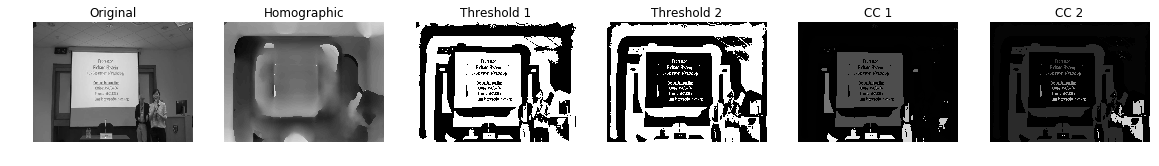

/home/void/Projects/OCR/Text-detection-in-natural-scene-images/lib/python3.6/site-packages/ipykernel_launcher.py:48: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/home/void/Projects/OCR/Text-detection-in-natural-scene-images/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/void/Projects/OCR/Text-detection-in-natural-scene-images/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Content is empty
Content is empty
Content is empty
Content is empty
Content is empty
Content is empty
Content is empty
Content is empty
Content is empty
Content is empty
Content is empty
{'text': '', 'timestamp_ms': '3200', 'line_content': ['Pro e sor', 'Rh d besten', 'of ho', 'Contact nform tion', 'oes 6', 'ho 6 26', "E '"], 'line_position': [((262, 148), (321, 165)), ((242, 173), (339, 191)), ((301, 198), (346, 211)), ((243, 236), (345, 249)), ((249, 259), (339, 271)), ((255, 280), (334, 293)), ((248, 303), (304, 315))]}


In [10]:
if __name__ == "__main__":
    location = "../Text-detection-in-natural-scene-images-dataset/text or no text dataset/testing/"
    frame = "3200.jpg"
    print(run_preprocessing(frame_location=frame, location=location))